In [120]:
import pandas as pd 
import numpy as np

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils import tensorboard
from torch.optim import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt

In [2]:
pl.seed_everything(42)

Seed set to 42


42

In [4]:
X = pd.read_csv("data/robot_surface/X_train.csv")
y = pd.read_csv("data/robot_surface/y_train.csv")

print(X.shape, y.shape)

(487680, 13) (3810, 3)


In [5]:
X.head(3)

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003386,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267


In [6]:
y.head(3)

,series_id,group_id,surface
0,0,13,fine_concrete
1,1,31,concrete
2,2,20,concrete


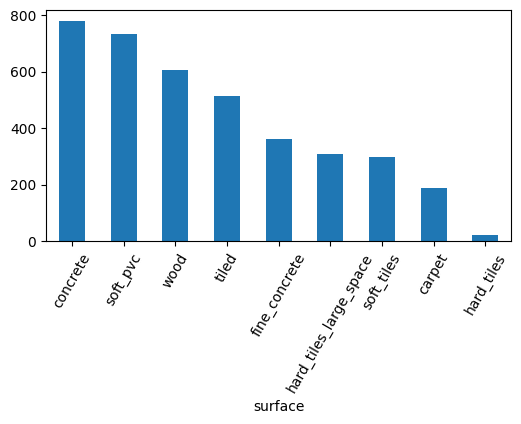

In [7]:
plt.figure(figsize=(6,3))
y.surface.value_counts().plot(kind="bar")
plt.xticks(rotation=60)
plt.show()

In [8]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(y.surface)

y["encoded_label"] = encoded_labels

In [9]:
y.sample(3)

,series_id,group_id,surface,encoded_label
1011,1011,7,carpet,0
3185,3185,60,carpet,0
3698,3698,60,carpet,0


In [10]:
FEATURE_COLUMNNS = X.columns[3:].to_list()

In [46]:
sequences = []

for series_id, group in X.groupby(by='series_id'):
    series = group[FEATURE_COLUMNNS].values
    label = y.iloc[series_id].encoded_label

    sequences.append((series, label))

In [48]:
train_sequences, test_sequences = train_test_split(sequences, train_size=0.75)

print(len(train_sequences), len(test_sequences))

2857 953


In [65]:
class CustomDataset(Dataset):
    def __init__(self, sequences):
        super().__init__()
        self.sequences = sequences        

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx][0]
        label = self.sequences[idx][1]

        return {
            'sequence': sequence,
            'label': label 
        }

In [66]:
from pytorch_lightning.utilities.types import EVAL_DATALOADERS, TRAIN_DATALOADERS

class DataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()

        self.train_sequences = train_sequences
        self.test_sequences = test_sequences

        self.batch_size = batch_size

    def setup(self, stage):
        self.train_dataset = CustomDataset(self.train_sequences)
        self.test_dataset = CustomDataset(self.test_sequences)
    
    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(
            dataset=self.train_dataset, batch_size=self.batch_size, shuffle=True
        )
    
    def val_dataloader(self) -> EVAL_DATALOADERS:
       return DataLoader(
            dataset=self.train_dataset, batch_size=self.batch_size, shuffle=False
        )
    
    def test_dataloader(self):
       return DataLoader(
            dataset=self.train_dataset, batch_size=self.batch_size, shuffle=False
        )
    

In [67]:
N_EPOCHS = 100
BATCH_SIZE = 32

data_module = DataModule(train_sequences, test_sequences, batch_size=BATCH_SIZE)

## LSTM ONLY MODEL

In [111]:
class LSTMOnly(nn.Module):
    def __init__(self, n_features, n_classes, num_layer=2, hidden_size=256):
        super().__init__()

        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=num_layer, batch_first=True, dropout=0.5)
        self.classifier = nn.Linear(hidden_size, n_classes)
        self.double()

    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)

        out = hidden[-1]

        return self.classifier(out)

## CNN-LSTM MODEL

## Training Phase

In [121]:
class SurfacePredictor(pl.LightningModule):
    def __init__(self, n_features, n_classes, model):
        super().__init__()

        self.model = model(n_features=n_features, n_classes=n_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        
        if labels is not None:            
            loss = self.criterion(output, labels)

        return loss, output
    
    def training_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label'].type(torch.LongTensor)

        loss, output = self(sequences, labels)
        predictions = torch.argmax(output, dim=1)        
        
        train_acc = accuracy_score(predictions, labels)
        self.log('train_loss', loss, prog_bar=True, logger=True)
        self.log('train_accuracy', train_acc, prog_bar=True, logger=True)

        return {'loss': loss, 'accuracy': train_acc}
    
    def validation_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label'].type(torch.LongTensor)

        loss, output = self(sequences, labels)
        predictions = torch.argmax(output, dim=1)        
        
        val_acc = accuracy_score(predictions, labels)
        self.log('val_loss', loss, prog_bar=True, logger=True)
        self.log('val_accuracy', val_acc, prog_bar=True, logger=True)

        return {'loss': loss, 'accuracy': val_acc}
    
    def test_step(self, batch, batch_idx):
        sequences = batch['sequence']
        labels = batch['label'].type(torch.LongTensor)

        loss, output = self(sequences, labels)
        predictions = torch.argmax(output, dim=1)        
        
        test_acc = accuracy_score(predictions, labels)
        self.log('test_loss', loss, prog_bar=True, logger=True)
        self.log('test_accuracy', test_acc, prog_bar=True, logger=True)

        return {'loss': loss, 'accuracy': test_acc}    
    
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.0001)

In [122]:
lstm_only = SurfacePredictor(n_features=len(FEATURE_COLUMNNS), n_classes=len(label_encoder.classes_), model=LSTMOnly)

In [34]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

Launching TensorBoard...

In [123]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger('lightning_logs', name='surface')
trainer = pl.Trainer(
logger=logger,
callbacks=[checkpoint_callback],
max_epochs=N_EPOCHS
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [124]:
trainer.fit(model=lstm_only, datamodule=data_module)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | LSTMOnly         | 803 K 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
803 K     Trainable params
0         Non-trainable params
803 K     Total params
3.212     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

d:\pythonEnvs\torch_dl\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


d:\pythonEnvs\torch_dl\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 90/90 [03:16<00:00,  0.46it/s, v_num=11, train_loss=1.940, train_accuracy=0.333, val_loss=2.000, val_accuracy=0.209]

Epoch 0, global step 90: 'val_loss' reached 2.00207 (best 2.00207), saving model to 'checkpoints\\best-checkpoint.ckpt' as top 1


Epoch 1: 100%|██████████| 90/90 [01:47<00:00,  0.84it/s, v_num=11, train_loss=1.620, train_accuracy=0.667, val_loss=1.930, val_accuracy=0.293] 

Epoch 1, global step 180: 'val_loss' reached 1.92632 (best 1.92632), saving model to 'checkpoints\\best-checkpoint.ckpt' as top 1


Epoch 2: 100%|██████████| 90/90 [01:04<00:00,  1.40it/s, v_num=11, train_loss=1.550, train_accuracy=0.556, val_loss=1.880, val_accuracy=0.296]

Epoch 2, global step 270: 'val_loss' reached 1.87989 (best 1.87989), saving model to 'checkpoints\\best-checkpoint.ckpt' as top 1


Epoch 3:   7%|▋         | 6/90 [00:03<00:43,  1.94it/s, v_num=11, train_loss=1.840, train_accuracy=0.281, val_loss=1.880, val_accuracy=0.296] 

d:\pythonEnvs\torch_dl\Lib\site-packages\pytorch_lightning\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
